In [1]:
import math
from sklearn.neighbors import NearestNeighbors
from matplotlib.collections import LineCollection
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd 

### curve
def hanging_line(point1, point2):
    a = (point2[1] - point1[1])/(np.cosh(point2[0]) - np.cosh(point1[0]))
    b = point1[1] - a*np.cosh(point1[0])
    x = np.linspace(point1[0], point2[0], 100)
    y = a*np.cosh(x) + b
    return (x,y)

In [2]:
import scanpy as sc
# adata=sc.read_h5ad('data/20220420_adata_final.h5ad')
import scanpy as sc
adata = sc.read_h5ad('K:\\AutoSeg_result\\sagittal1\\annotation\\adata_all_052223.h5ad')

In [4]:
Plot_Rank4 = 'Cerebellum neurons'

In [5]:
adata_sub = adata[adata.obs['Rank4_Defined'] == Plot_Rank4,:].copy()

In [6]:
intersect_gene = np.intersect1d(adata_sub.raw.var.index, adata_sub.var.index)
adata_sub_raw_X = adata_sub.raw[:,intersect_gene].X

maxRNAcount=np.array(adata_sub_raw_X).max(axis=0)
adata_sub=adata_sub[:,intersect_gene][:,maxRNAcount>10]

In [7]:
# Run PCA
sc.tl.pca(adata_sub, n_comps =50,svd_solver='arpack')
sc.pp.neighbors(adata_sub, n_neighbors=30, n_pcs=50)
sc.tl.umap(adata_sub)
sc.tl.leiden(adata_sub, resolution=0.5)

In [8]:
cluster_pl=list(np.random.rand(len(adata_sub.obs['Rank5_Symbol_1008'] .unique()),3))


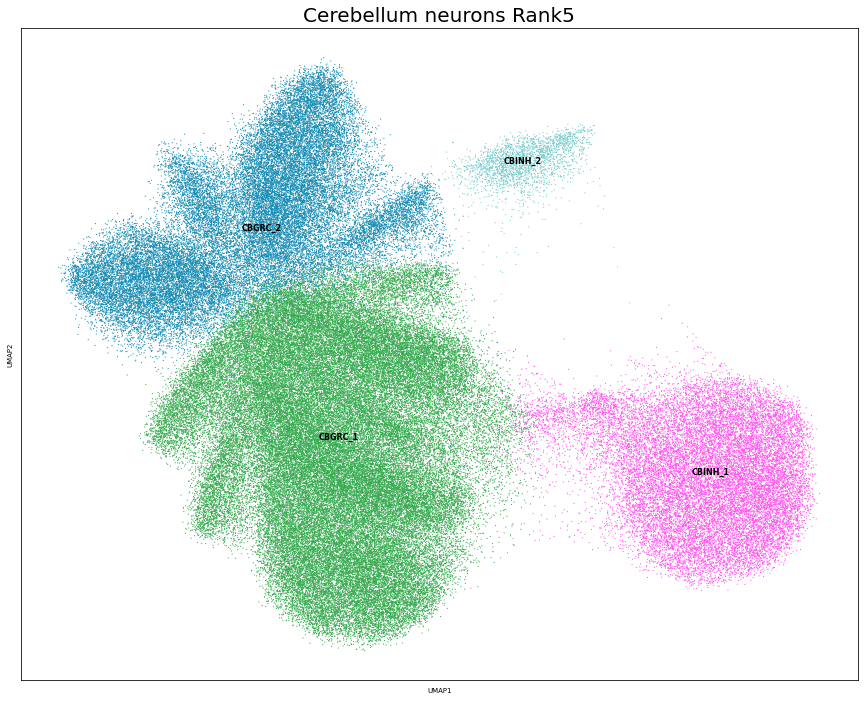

In [9]:
fig,ax = plt.subplots(figsize=(15,12))
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(7)
ax=sc.pl.umap(adata_sub,size=5, 
              legend_loc='on data',color='Rank5_Symbol_1008',
              legend_fontsize=8,
              palette = cluster_pl,
              ax=ax,show=False)
ax.set_title(Plot_Rank4 + ' Rank5')
ax.title.set_fontsize(20)
# fig.savefig(Plot_Rank4 + 'UMAP_full.png',dpi = 300)

# find gene markers


In [10]:
sc.tl.rank_genes_groups(adata_sub, 'Rank5_Symbol_1008', method='t-test')

In [11]:
markers = []
markers_pval_row=[]
markers_row=[]

temp = pd.DataFrame(adata_sub.uns['rank_genes_groups']['names']).head(3)
temp_score = pd.DataFrame(adata_sub.uns['rank_genes_groups']['scores']).head(3)
temp_pvale = pd.DataFrame(adata_sub.uns['rank_genes_groups']['pvals']).head(3)

for i in range(temp.shape[1]):
    curr_col = temp.iloc[:, i].to_list()
    curr_col_score = temp_score.iloc[:, i].to_list()
    curr_col_pvale=temp_pvale.iloc[:, i].to_list()
    list_true=[x>0 for x in curr_col_score]
    curr_col=list(np.array(curr_col)[list_true])
    curr_col_pvale=list(np.array(curr_col_pvale)[list_true])
    
    markers = markers + curr_col
    markers_row.append(curr_col)
    markers_pval_row.append(curr_col_pvale)
    print(i, curr_col)

0 ['CBLN3', 'AQP4', 'CRISP1']
1 ['CNKSR3', 'CALB2', 'CBLN1']
2 ['PVALB', 'GAD1', 'KIT']
3 ['SOST', 'NREP', 'PENK']


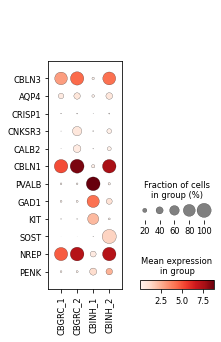

In [12]:
markers_apper=[]
for i in markers:
    if i not in markers_apper:
        markers_apper.append(i)        
        
        
axes=sc.pl.dotplot(adata_sub, markers_apper, 
                   groupby='Rank5_Symbol_1008', swap_axes=True,return_fig=True)
axes.savefig('DotPlot_full.png',dpi = 300)